In [69]:
import pandas as pd

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df = pd.read_csv(url)

# Aggregate at country level
country_level = df[~(df['Province/State'].str.contains(', ', na=False))].drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()

def align(data):
    # Find the index with the lowest non-zero starting case number
    base = min(((idx, val) for (idx, val) in enumerate(data) if val[0] > 0), key = lambda x: x[1][0])[0]

    # Align everyone else to this base
    for i in [x for x in range(len(data)) if x != base]:
        padding = min(((x[0], abs(x[1] - data[i][0])) for x in enumerate(data[base])), key = lambda x: x[1])[0]
        data[i] = [0 for i in range(padding)] + data[i]
    return data

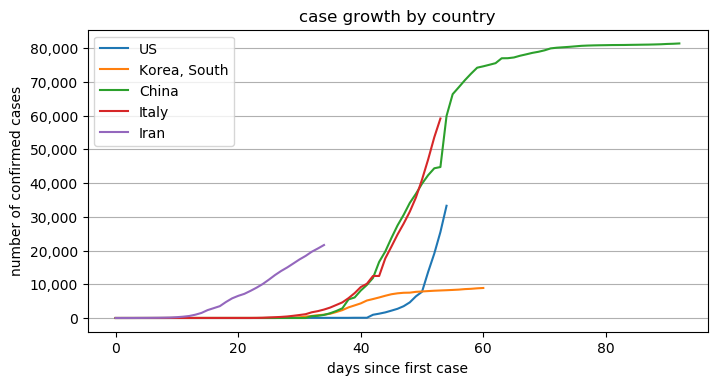

In [70]:
from pylab import *

# Countries to compare
inputs = ['US', 'Korea, South', 'China', 'Italy', 'Iran']
data = align([[x for x in country_level.loc[inputs[i]].values.tolist() if x > 0] for i in range(len(inputs))])

fig, axes = plt.subplots(figsize=(8,4), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = inputs[i])

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('case growth by country');
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
plt.grid(axis='y')
fig.savefig("covid-by-country.png", dpi=200)

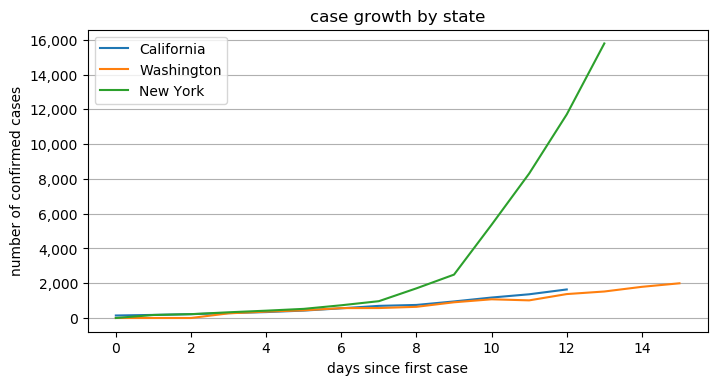

In [75]:
inputs = ['California', 'Washington', 'New York']
us_by_state = df[~(df['Province/State'].str.contains(', ', na=False))].drop(['Lat', 'Long'], axis=1).groupby('Province/State').sum()
data = align([[x for x in us_by_state.loc[inputs[i]].values.tolist() if x > 0] for i in range(len(inputs))])

fig, axes = plt.subplots(figsize=(8,4), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = inputs[i])

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('case growth by state');
#axes.set_yscale('log')
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
plt.grid(axis='y')
fig.savefig("covid-by-us-state.png", dpi=200)